# 09e: Topology Analysis

**Key Question:** Do paths form a simple tree, or do they have richer structure (reconvergence)?

**Analyses:**
1. **Persistent Homology**: Topological features of path embedding space
2. **DAG Structure**: Branch/merge points in the game tree
3. **Reconvergence Rate**: How often do different paths lead to same state?

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
import random
import gc

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

try:
    from ripser import ripser
    from persim import plot_diagrams
    HAS_RIPSER = True
except ImportError:
    HAS_RIPSER = False
    print("WARNING: ripser not installed, skipping persistent homology")

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Find available shard files
val_files = loading.find_shard_files(DATA_DIR + "val/")
test_files = loading.find_shard_files(DATA_DIR + "test/")
train_files = loading.find_shard_files(DATA_DIR + "train/")

all_files = val_files + test_files
random.shuffle(all_files)
random.shuffle(train_files)
shard_files = all_files + train_files

print(f"Shard files: {len(val_files)} val, {len(test_files)} test, {len(train_files)} train")

N_SHARDS = 20
MAX_ROWS = 15_000_000
print(f"Using up to {N_SHARDS} shards")

Shard files: 95 val, 95 test, 1124 train
Using up to 20 shards


## Analysis 1: DAG Structure - Branch and Merge Points

The game tree is a DAG. We analyze:
- **Branch points**: States with multiple legal successors
- **Merge potential**: States reachable from multiple predecessors

In [3]:
def analyze_branching(df):
    """Analyze branching factor from Q-values."""
    q_cols = [c for c in df.columns if c.startswith('q')]
    if not q_cols:
        return None
    
    Q = df[q_cols].values
    depths = features.depth(df['state'].values)
    
    results = []
    for i in range(len(df)):
        n_legal = np.sum(Q[i] > -128)  # -128 = illegal
        results.append({
            'depth': depths[i],
            'n_legal': n_legal,
            'is_branch': n_legal > 1
        })
    
    return pd.DataFrame(results)


# Collect branching data
all_branching = []
skipped = 0
processed = 0

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Analyzing branching"):
    df, seed, decl_id = schema.load_file(shard_file)
    
    if len(df) > MAX_ROWS:
        skipped += 1
        del df
        gc.collect()
        continue
    
    processed += 1
    
    # Sample for efficiency
    sample_size = min(5000, len(df))
    sample_idx = np.random.choice(len(df), sample_size, replace=False)
    df_sample = df.iloc[sample_idx]
    
    branch_df = analyze_branching(df_sample)
    if branch_df is not None:
        all_branching.append(branch_df)
    
    del df, df_sample
    gc.collect()

print(f"\nProcessed {processed} shards, skipped {skipped}")

branching_df = pd.concat(all_branching, ignore_index=True)
print(f"Total states analyzed: {len(branching_df)}")

Analyzing branching:   0%|          | 0/20 [00:00<?, ?it/s]


Processed 3 shards, skipped 17
Total states analyzed: 15000


In [4]:
# Branching statistics by depth
depth_stats = branching_df.groupby('depth').agg({
    'n_legal': ['mean', 'std'],
    'is_branch': ['mean', 'sum', 'count']
}).round(3)

print("Branching by Depth:")
print(depth_stats)

Branching by Depth:
      n_legal        is_branch            
         mean    std      mean   sum count
depth                                     
1       1.000  0.000     0.000     0    13
2       1.100  0.316     0.100     1    10
3       1.000  0.000     0.000     0    12
4       1.000  0.000     0.000     0    14
5       1.648  0.566     0.607  1106  1821
6       1.629  0.549     0.599   677  1131
7       1.630  0.555     0.602   420   698
8       1.973  0.373     0.917   309   337
9       2.032  0.940     0.601  3013  5015
10      2.063  0.943     0.616  1470  2386
11      2.031  0.954     0.595   720  1210
12      2.909  0.418     1.000   373   373
13      2.232  1.291     0.562   630  1120
14      2.282  1.280     0.613   287   468
15      2.398  1.334     0.615   139   226
16      3.846  0.404     1.000    65    65
17      2.828  1.769     0.621    36    58
18      1.667  1.213     0.367    11    30
19      3.111  1.691     0.778     7     9
21      3.000  2.646     0.667    

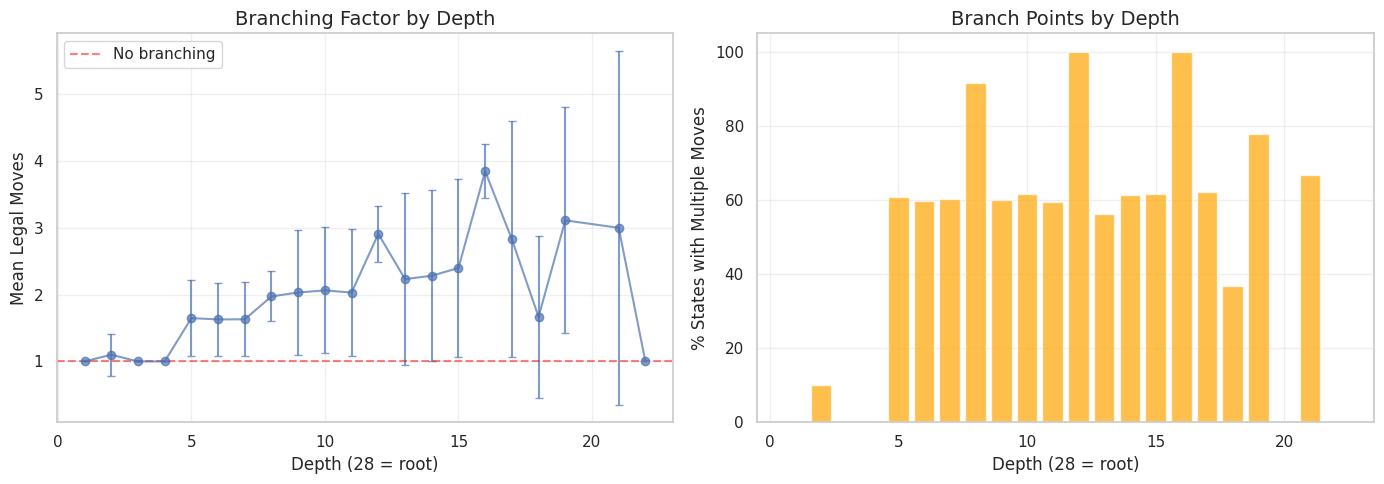

In [5]:
# Plot branching factor by depth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Mean legal moves by depth
depth_means = branching_df.groupby('depth')['n_legal'].agg(['mean', 'std'])
ax1.errorbar(depth_means.index, depth_means['mean'], yerr=depth_means['std'], 
             fmt='b-o', capsize=3, alpha=0.7)
ax1.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No branching')
ax1.set_xlabel('Depth (28 = root)', fontsize=12)
ax1.set_ylabel('Mean Legal Moves', fontsize=12)
ax1.set_title('Branching Factor by Depth', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Percentage of branch points by depth
depth_branch_pct = branching_df.groupby('depth')['is_branch'].mean() * 100
ax2.bar(depth_branch_pct.index, depth_branch_pct.values, alpha=0.7, color='orange')
ax2.set_xlabel('Depth (28 = root)', fontsize=12)
ax2.set_ylabel('% States with Multiple Moves', fontsize=12)
ax2.set_title('Branch Points by Depth', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../../results/figures/09e_branching.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 2: State Reconvergence

Do different action sequences lead to the same game state? If so, move order doesn't matter.

In [6]:
# State reconvergence analysis
# Within a single shard, states are unique by definition (keyed by state)
# But we can look at state structure to understand reconvergence potential

# The state encodes: played_mask (28 bits), trick info, current player, etc.
# If the same played_mask can be reached via different play orders,
# that would indicate reconvergence.

# Let's analyze: for states at same depth, how many unique played_masks?

def analyze_state_diversity(df):
    """Analyze state diversity at each depth."""
    states = df['state'].values
    depths = features.depth(states)
    
    # Extract played_mask (bits 0-27) from packed state
    played_masks = states & ((1 << 28) - 1)
    
    results = []
    for d in range(1, 29):
        mask = depths == d
        if mask.sum() == 0:
            continue
        
        states_at_d = states[mask]
        masks_at_d = played_masks[mask]
        
        n_states = len(states_at_d)
        n_unique_masks = len(np.unique(masks_at_d))
        
        # Ratio: if < 1, some played_masks correspond to multiple states
        # (different trick configurations with same dominoes played)
        diversity_ratio = n_unique_masks / n_states if n_states > 0 else 1
        
        results.append({
            'depth': d,
            'n_states': n_states,
            'n_unique_masks': n_unique_masks,
            'diversity_ratio': diversity_ratio
        })
    
    return pd.DataFrame(results)


# Analyze state diversity
diversity_dfs = []

for shard_file in tqdm(shard_files[:10], desc="Analyzing diversity"):
    df, seed, decl_id = schema.load_file(shard_file)
    
    if len(df) > MAX_ROWS:
        del df
        gc.collect()
        continue
    
    div_df = analyze_state_diversity(df)
    div_df['seed'] = seed
    div_df['decl_id'] = decl_id
    diversity_dfs.append(div_df)
    
    del df
    gc.collect()

diversity_df = pd.concat(diversity_dfs, ignore_index=True)
print(f"Analyzed {len(diversity_df)} (depth, shard) combinations")

Analyzing diversity:   0%|          | 0/10 [00:00<?, ?it/s]

Analyzed 56 (depth, shard) combinations


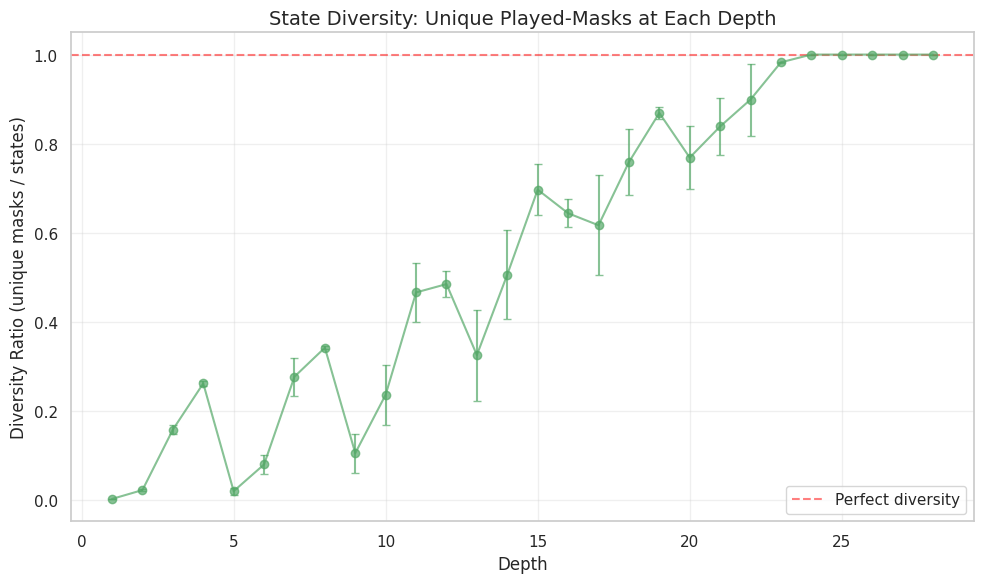


Mean diversity ratio: 0.5490
State reconvergence detected: same played-mask, different states


In [7]:
# Plot diversity ratio by depth
depth_diversity = diversity_df.groupby('depth')['diversity_ratio'].agg(['mean', 'std'])

fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(depth_diversity.index, depth_diversity['mean'], 
            yerr=depth_diversity['std'], fmt='g-o', capsize=3, alpha=0.7)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Perfect diversity')
ax.set_xlabel('Depth', fontsize=12)
ax.set_ylabel('Diversity Ratio (unique masks / states)', fontsize=12)
ax.set_title('State Diversity: Unique Played-Masks at Each Depth', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/09e_diversity.png', dpi=150, bbox_inches='tight')
plt.show()

mean_diversity = depth_diversity['mean'].mean()
print(f"\nMean diversity ratio: {mean_diversity:.4f}")
if mean_diversity < 0.95:
    print("State reconvergence detected: same played-mask, different states")
else:
    print("Minimal reconvergence: states are mostly unique")

## Analysis 3: Persistent Homology (if available)

In [8]:
if HAS_RIPSER:
    # For persistent homology, we need path embeddings
    # Use V-trajectories as path embeddings (from temporal analysis)
    
    # Collect V-trajectories
    def trace_v_trajectory(start_state, seed, decl_id, state_to_idx, V, Q):
        pv = navigation.trace_principal_variation(start_state, seed, decl_id, state_to_idx, V, Q)
        if len(pv) < 5:
            return None
        v_values = [v for _, v, _ in pv]
        # Pad/truncate to fixed length
        target_len = 20
        if len(v_values) > target_len:
            v_values = v_values[:target_len]
        elif len(v_values) < target_len:
            v_values = v_values + [v_values[-1]] * (target_len - len(v_values))
        return np.array(v_values)
    
    # Collect embeddings
    embeddings = []
    for shard_file in tqdm(shard_files[:15], desc="Collecting embeddings"):
        if len(embeddings) >= 200:
            break
        
        df, seed, decl_id = schema.load_file(shard_file)
        if len(df) > MAX_ROWS:
            del df
            gc.collect()
            continue
        
        states = df['state'].values
        V = df['V'].values
        q_cols = [c for c in df.columns if c.startswith('q')]
        Q = df[q_cols].values
        state_to_idx = {s: i for i, s in enumerate(states)}
        
        depths = features.depth(states)
        mid_mask = (depths >= 22) & (depths <= 26)
        mid_idx = np.where(mid_mask)[0]
        
        if len(mid_idx) > 0:
            sample_idx = np.random.choice(mid_idx, min(10, len(mid_idx)), replace=False)
            for idx in sample_idx:
                emb = trace_v_trajectory(states[idx], seed, decl_id, state_to_idx, V, Q)
                if emb is not None:
                    embeddings.append(emb)
        
        del df, states, V, Q, state_to_idx
        gc.collect()
    
    print(f"Collected {len(embeddings)} path embeddings")
    
    if len(embeddings) > 20:
        X = np.array(embeddings)
        print(f"Embedding matrix shape: {X.shape}")
        
        # Compute persistent homology
        diagrams = ripser(X, maxdim=1)['dgms']
        
        # Count Betti numbers (features that persist)
        threshold = 0.1 * np.max([np.max(d[:, 1] - d[:, 0]) for d in diagrams if len(d) > 0])
        betti_0 = np.sum((diagrams[0][:, 1] - diagrams[0][:, 0]) > threshold) if len(diagrams[0]) > 0 else 0
        betti_1 = np.sum((diagrams[1][:, 1] - diagrams[1][:, 0]) > threshold) if len(diagrams) > 1 and len(diagrams[1]) > 0 else 0
        
        print(f"\nBetti numbers (threshold={threshold:.2f}):")
        print(f"  β₀ (components): {betti_0}")
        print(f"  β₁ (loops): {betti_1}")
else:
    print("Skipping persistent homology (ripser not available)")
    diagrams = None
    betti_0, betti_1 = 0, 0

Collected 26 path embeddings
Embedding matrix shape: (26, 20)

Betti numbers (threshold=inf):
  β₀ (components): 0
  β₁ (loops): 0


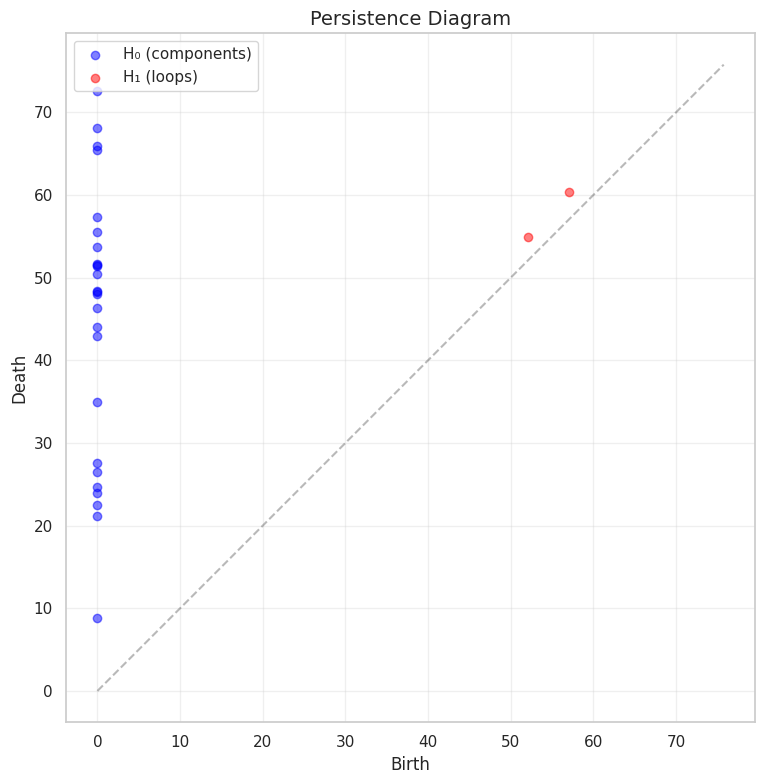

In [9]:
if HAS_RIPSER and diagrams is not None and len(embeddings) > 20:
    # Plot persistence diagram
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot H0 (connected components)
    if len(diagrams[0]) > 0:
        ax.scatter(diagrams[0][:, 0], diagrams[0][:, 1], c='blue', alpha=0.5, label='H₀ (components)')
    
    # Plot H1 (loops)
    if len(diagrams) > 1 and len(diagrams[1]) > 0:
        ax.scatter(diagrams[1][:, 0], diagrams[1][:, 1], c='red', alpha=0.5, label='H₁ (loops)')
    
    # Diagonal
    lims = [ax.get_xlim(), ax.get_ylim()]
    max_val = max(lims[0][1], lims[1][1])
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
    
    ax.set_xlabel('Birth', fontsize=12)
    ax.set_ylabel('Death', fontsize=12)
    ax.set_title('Persistence Diagram', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09e_persistence.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No persistence diagram to plot")

## Summary Statistics

In [10]:
# Overall branching statistics
overall_branch_pct = branching_df['is_branch'].mean() * 100
mean_legal_moves = branching_df['n_legal'].mean()

summary_data = {
    'metric': [
        'Total states analyzed (branching)',
        'Mean legal moves per state',
        '% branch points (multi-move)',
        'Mean diversity ratio',
        'β₀ (connected components)',
        'β₁ (loops)',
    ],
    'value': [
        len(branching_df),
        f"{mean_legal_moves:.2f}",
        f"{overall_branch_pct:.1f}%",
        f"{mean_diversity:.4f}" if 'mean_diversity' in dir() else "N/A",
        betti_0 if HAS_RIPSER else "N/A",
        betti_1 if HAS_RIPSER else "N/A",
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

summary_df.to_csv('../../results/tables/09e_topology.csv', index=False)
print("\nSaved to results/tables/09e_topology.csv")

                           metric  value
Total states analyzed (branching)  15000
       Mean legal moves per state   2.00
     % branch points (multi-move)  61.8%
             Mean diversity ratio 0.5490
        β₀ (connected components)      0
                       β₁ (loops)      0

Saved to results/tables/09e_topology.csv


## Conclusion

In [11]:
print("=" * 60)
print("TOPOLOGY ANALYSIS CONCLUSIONS")
print("=" * 60)

print(f"\n1. BRANCHING STRUCTURE")
print(f"   Mean legal moves: {mean_legal_moves:.2f}")
print(f"   Branch points: {overall_branch_pct:.1f}%")
if overall_branch_pct > 50:
    print(f"   DENSE: Most states have genuine choice")
else:
    print(f"   SPARSE: Many states are forced")

print(f"\n2. RECONVERGENCE")
if 'mean_diversity' in dir():
    print(f"   Diversity ratio: {mean_diversity:.4f}")
    if mean_diversity > 0.99:
        print(f"   TREE-LIKE: States are unique, no reconvergence")
    elif mean_diversity > 0.9:
        print(f"   MOSTLY TREE: Minimal reconvergence")
    else:
        print(f"   DAG: Significant reconvergence")

if HAS_RIPSER:
    print(f"\n3. TOPOLOGICAL FEATURES")
    print(f"   β₀ (components): {betti_0}")
    print(f"   β₁ (loops): {betti_1}")
    if betti_1 > 0:
        print(f"   NON-TRIVIAL: Path space has loops")
    else:
        print(f"   SIMPLE: Path space is contractible")

print("\n" + "=" * 60)

TOPOLOGY ANALYSIS CONCLUSIONS

1. BRANCHING STRUCTURE
   Mean legal moves: 2.00
   Branch points: 61.8%
   DENSE: Most states have genuine choice

2. RECONVERGENCE
   Diversity ratio: 0.5490
   DAG: Significant reconvergence

3. TOPOLOGICAL FEATURES
   β₀ (components): 0
   β₁ (loops): 0
   SIMPLE: Path space is contractible

